## Housing Values in  Boston


### Data description

The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

crim :
per capita crime rate by town.

zn :
proportion of residential land zoned for lots over 25,000 sq.ft.

indus :
proportion of non-retail business acres per town.

chas :
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

nox :
nitrogen oxides concentration (parts per 10 million).

rm :
average number of rooms per dwelling.

age :
proportion of owner-occupied units built prior to 1940.

dis:
weighted mean of distances to five Boston employment centres.

rad :
index of accessibility to radial highways.

tax : 
full-value property-tax rate per $10,000.

ptratio :
pupil-teacher ratio by town.

black :
1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

lstat:
lower status of the population (percent).

medv :
median value of owner-occupied homes in $1000s.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
import sklearn.model_selection as ms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

pd.options.display.max_rows = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
housing = pd.read_csv('Boston.csv')
housing.columns
housing=housing.drop(['Unnamed: 0'],axis=1)
housing.head(3)

Index(['Unnamed: 0', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis',
       'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7

In [3]:
housing.shape
housing.isnull().any()

(506, 14)

crim       False
zn         False
indus      False
chas       False
nox        False
rm         False
age        False
dis        False
rad        False
tax        False
ptratio    False
black      False
lstat      False
medv       False
dtype: bool

The Boston housing dataset is small dataset with 506 rowns and 14 columns and there are no nulls in the dataset so imputer is no needed here.

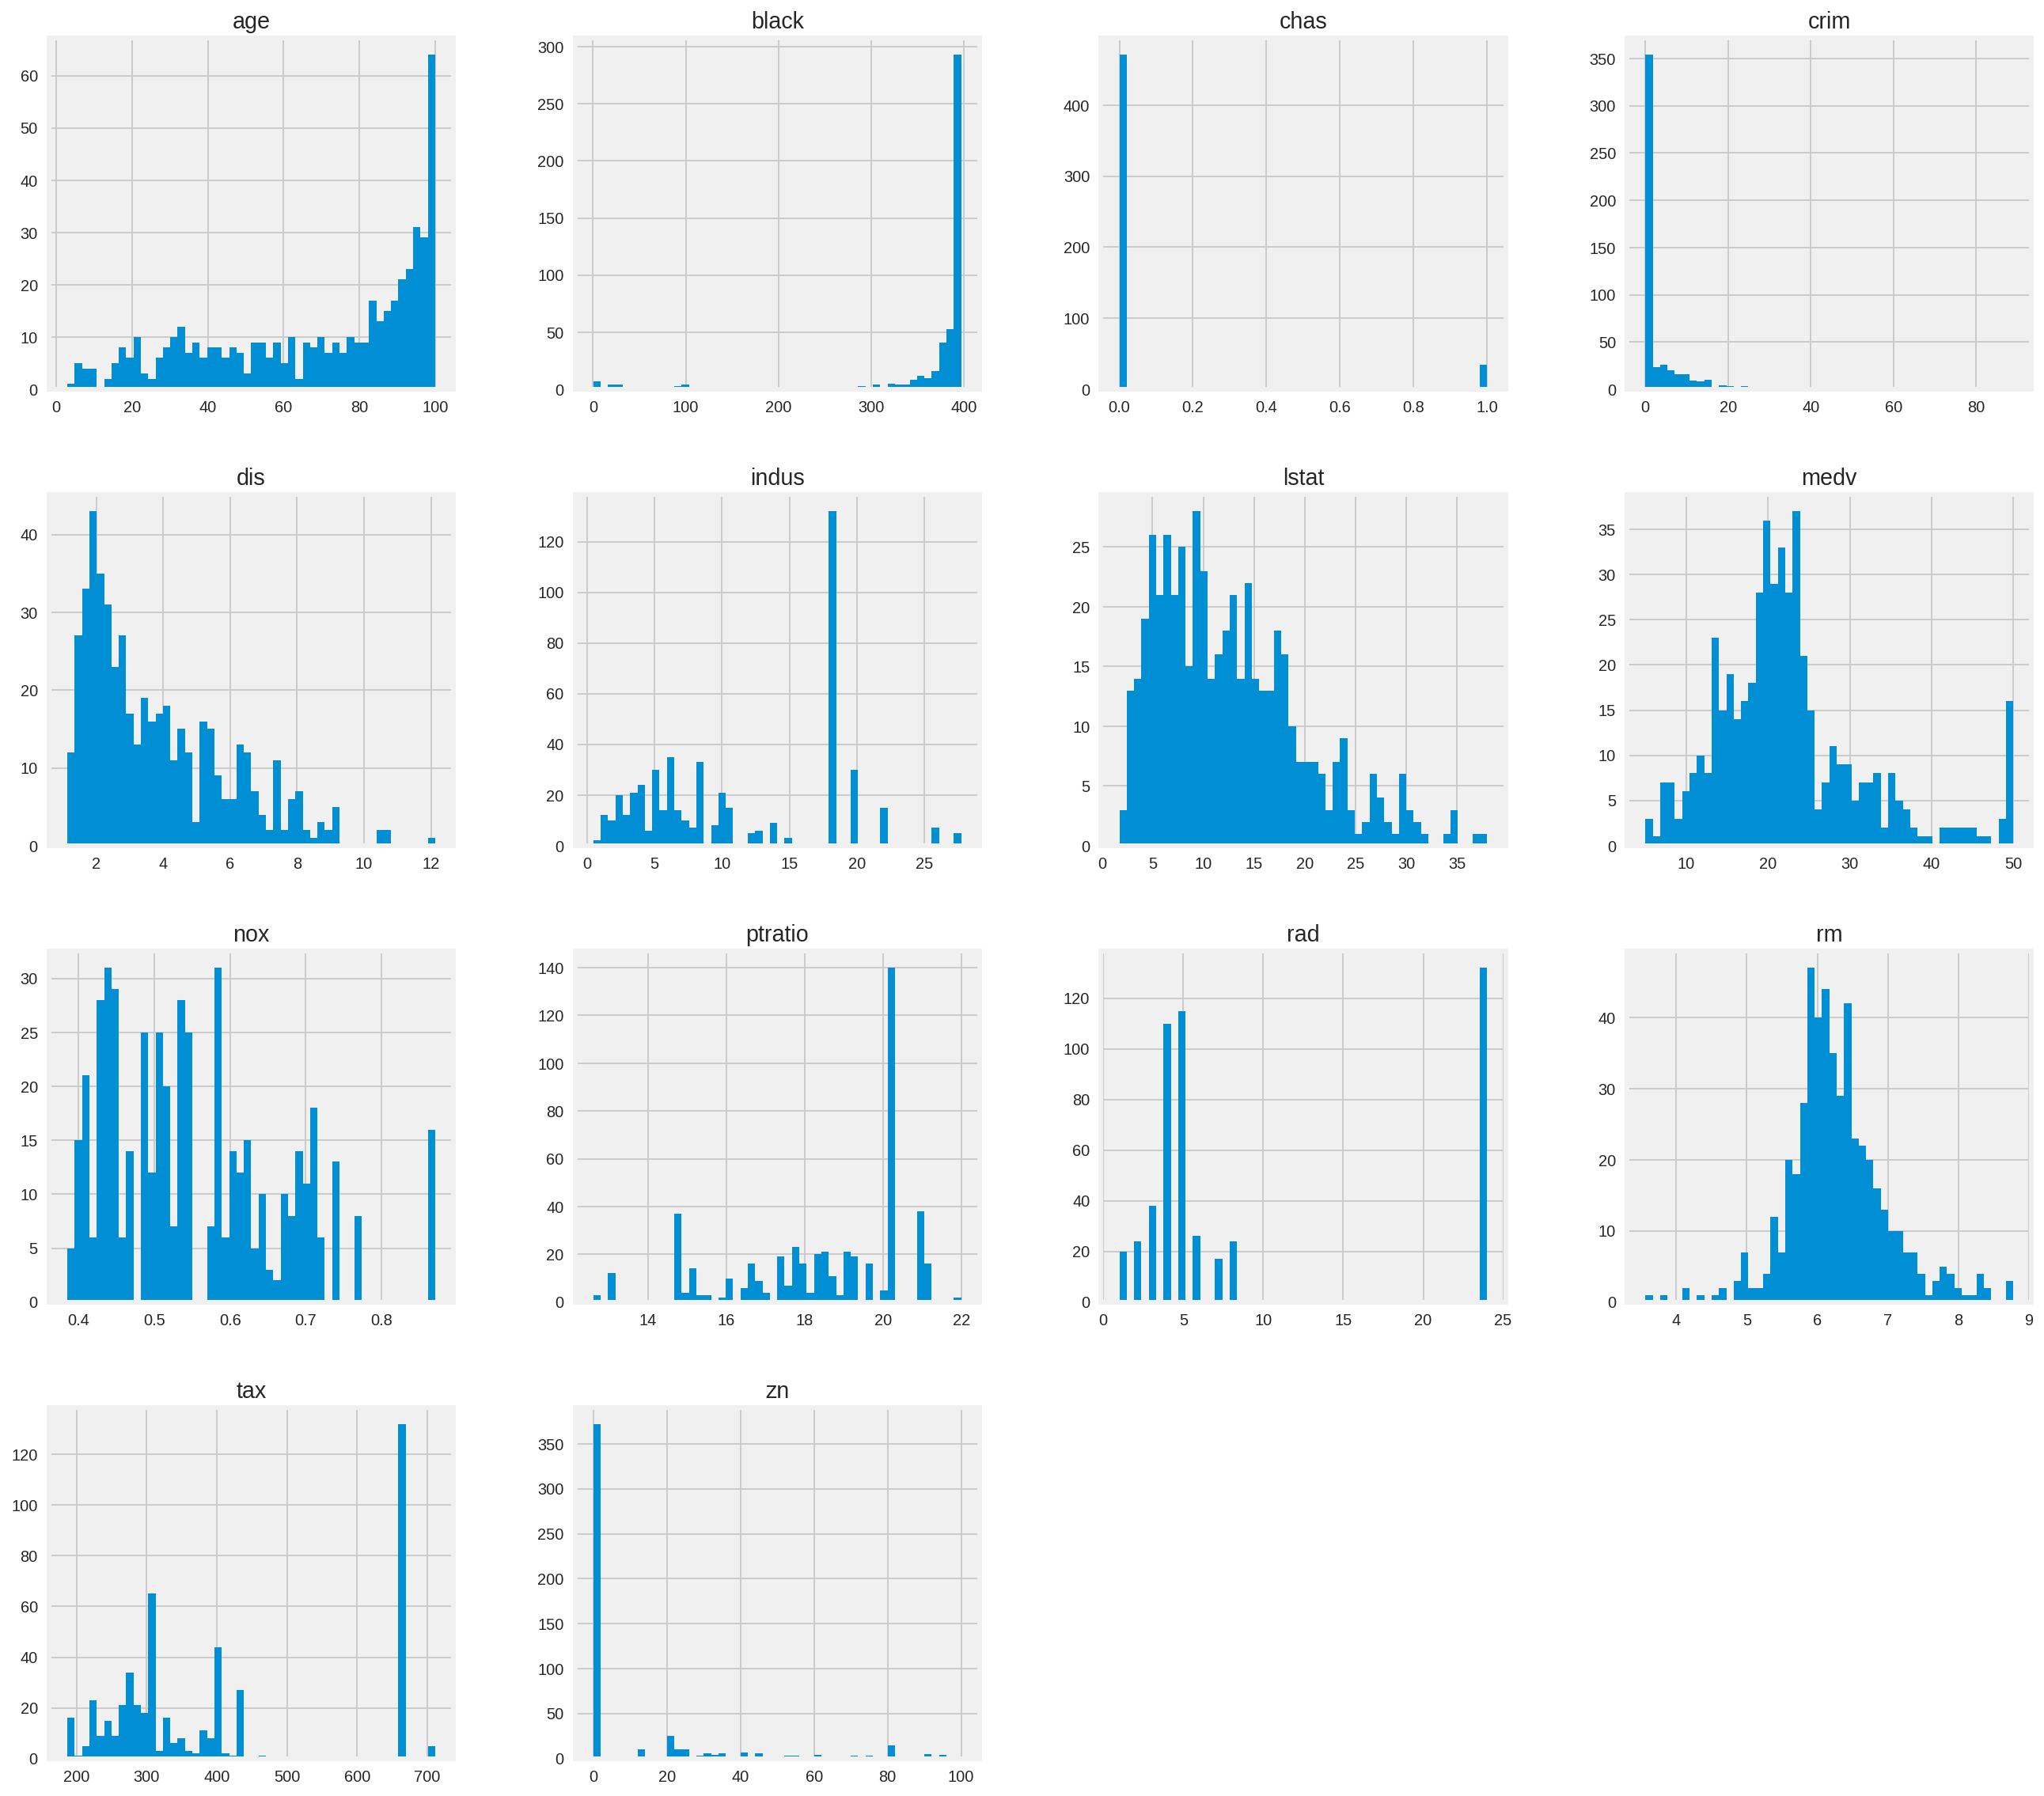

In [4]:
x=housing.hist(bins=50, figsize=(20, 20))
plt.show()

From the above histogram plot there are some outlayers in some of the colums so to figure them out distplot is useful

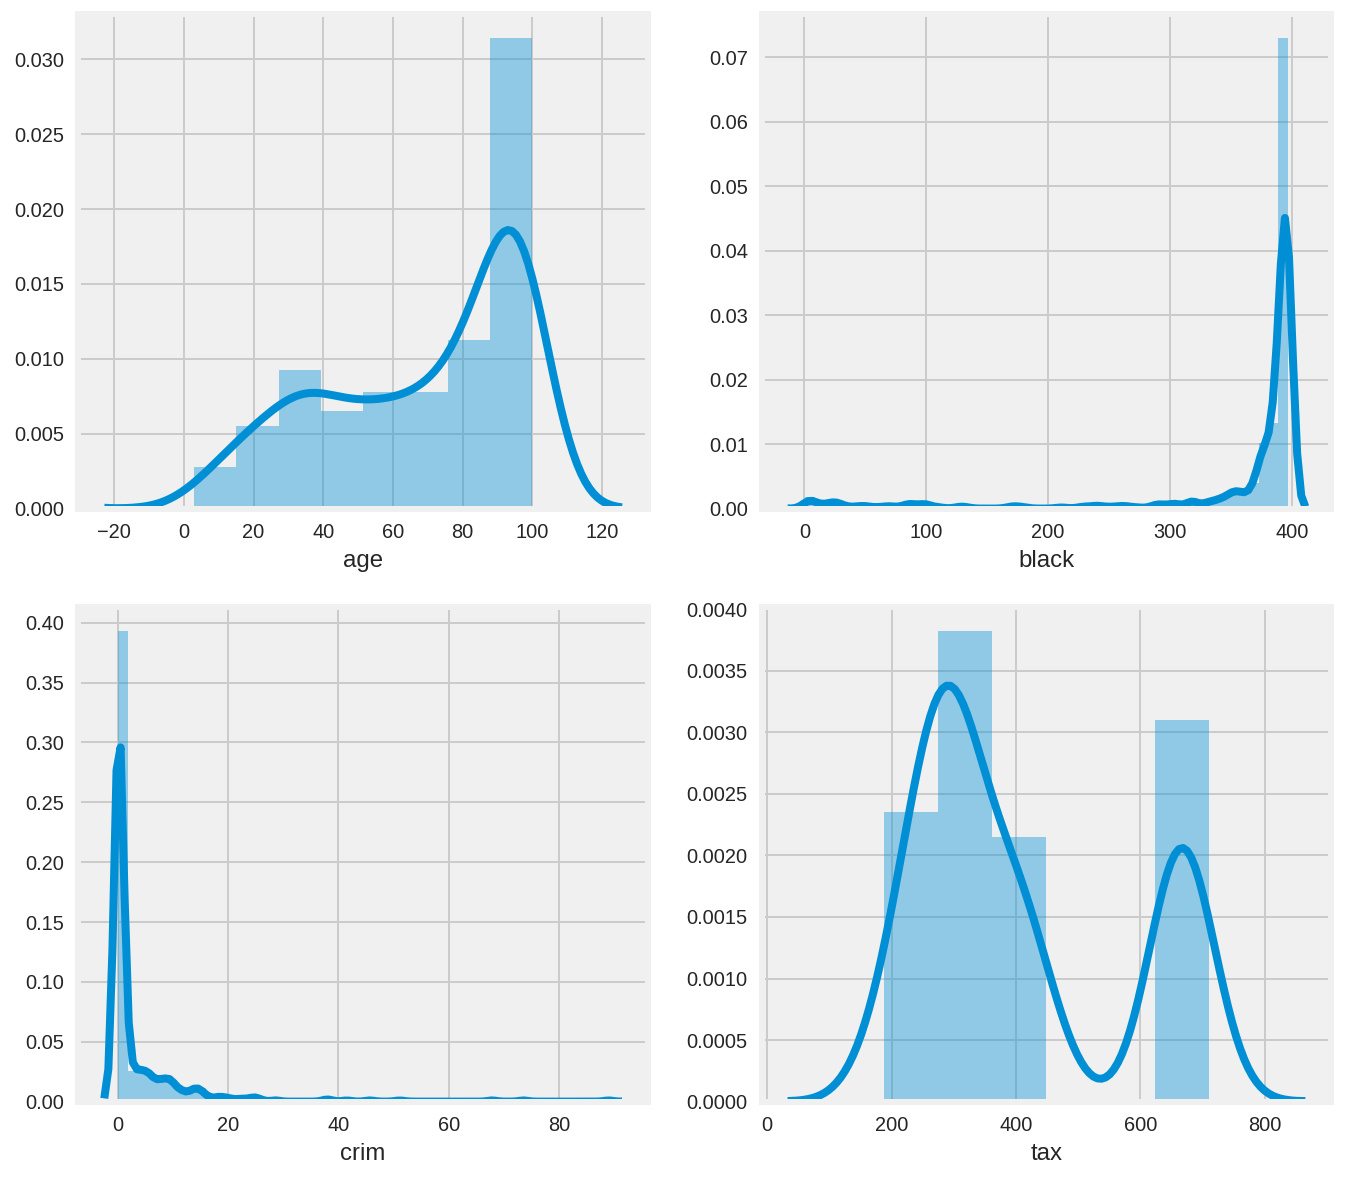

In [5]:
fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
a=sns.distplot(housing['age'],kde =True,ax=ax[0][0])
b=sns.distplot(housing['black'],kde =True,ax=ax[0][1])
c=sns.distplot(housing['crim'],kde = True,ax=ax[1][0])
d=sns.distplot(housing['tax'],kde = True,ax=ax[1][1])

Finding the correlation between the columns and figuring out then best between them and categorizing the data 
with strong correlated column

In [6]:
corr_matrix2 = housing.corr()
corr_matrix2 = np.abs(corr_matrix2)
corr_matrix2.medv.sort_values(ascending=False)

medv       1.000000
lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
crim       0.388305
rad        0.381626
age        0.376955
zn         0.360445
black      0.333461
dis        0.249929
chas       0.175260
Name: medv, dtype: float64

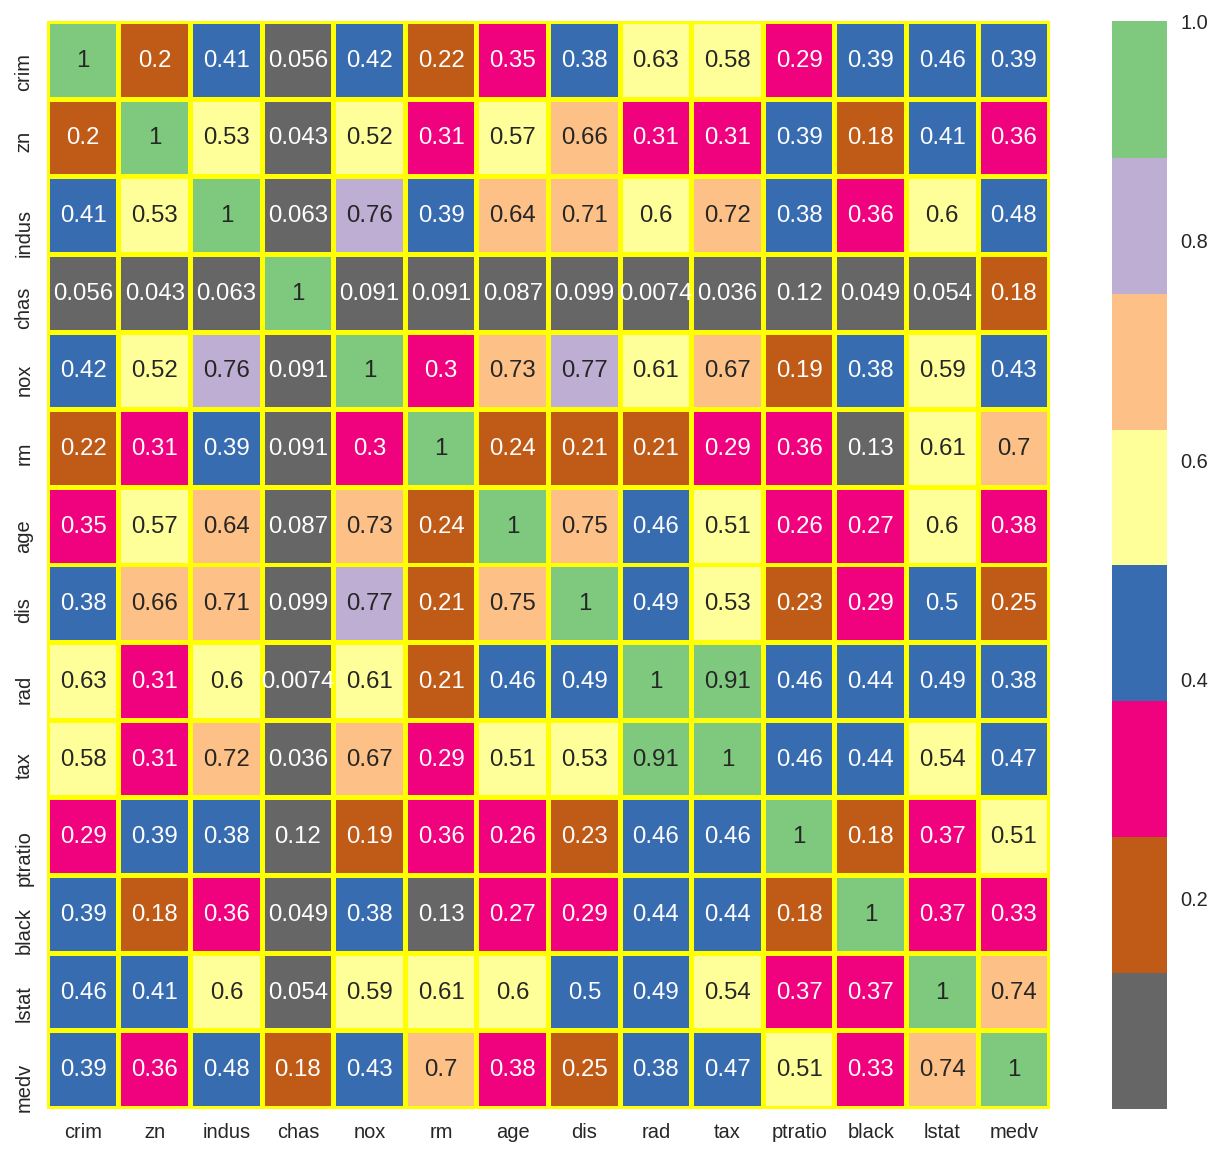

In [34]:
x=sns.set(rc={'figure.figsize':(10,10)})
x=sns.heatmap(corr_matrix2, vmin=None, vmax=None, cmap='Accent_r', center=None, robust=False, 
            annot=True, fmt='.2g', annot_kws=None, linewidths=2, linecolor='yellow', cbar=True,
            cbar_kws=None, cbar_ax=None, square=False, ax=None, xticklabels=True, yticklabels=True, mask=None)

From the above heat map i figured out that only some columns are highly correlated to each other and remaining have other type of relation(maybe non-linear type)

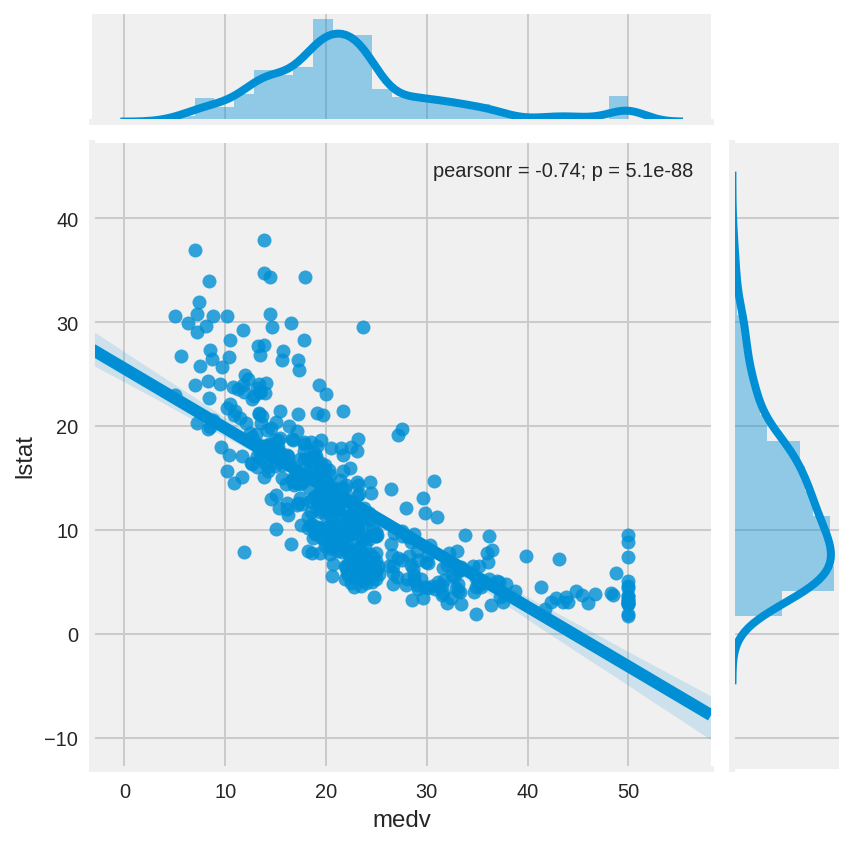

In [8]:
y=sns.jointplot("medv", "lstat", data=housing, kind="reg")

For splitting out the data 'lstat' which i figured out from above plots stands best for categorising and splitting which yields best result

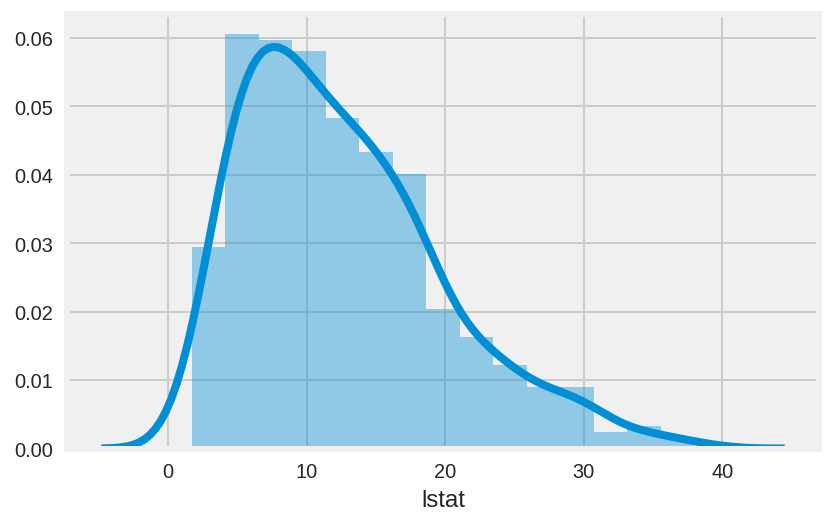

In [9]:
a=sns.distplot(housing['lstat']) ##lstat distplot figuring out the parameter to tune and make them into categories
categories = housing['lstat'] // 4.5

(0.0, 7.0)

array([ 1.,  2.,  0.,  4.,  6.,  3.,  5.,  7.])

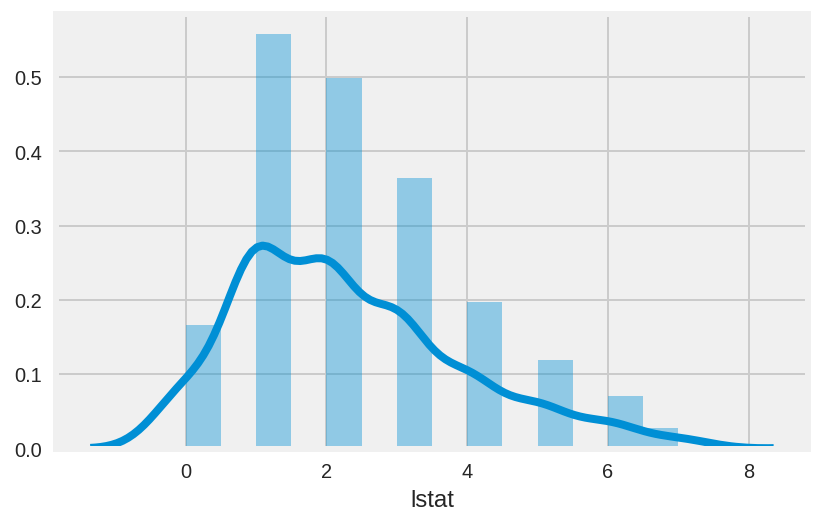

In [10]:
categories[categories >= 7] = 7
a=sns.distplot(categories)
categories.min(), categories.max()
categories.unique()

Stratified splitting with random state =42

In [11]:
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for training_indices, test_indices in split.split(housing, categories):
    stratified_train_set = housing.loc[training_indices]
    stratified_test_set = housing.loc[test_indices]
stratified_train_set.shape
stratified_test_set.shape

(404, 14)

(102, 14)

Random splitting with random state=42

In [12]:
rn_train_set, rn_test_set = ms.train_test_split(housing, test_size = 0.2, random_state=42)  
rn_train_set.shape
rn_test_set.shape

(404, 14)

(102, 14)

In [13]:
h = housing.groupby(categories).size() / len(housing)
h.name = 'housing'
str_train = stratified_train_set.groupby(categories).size() / len(stratified_train_set)
str_train.name = 'stratified train'
rn_train = rn_train_set.groupby(categories).size() / len(rn_train_set)
rn_train.name = 'random train'

Comparing and figuring out which split is best

In [14]:
compare = pd.concat([h, str_train, rn_train], axis=1)
compare['stratified train %'] = 100 * (compare['stratified train'] - compare['housing']) / compare['housing']
compare['random train %'] = 100 * (compare['random train'] - compare['housing']) / compare['housing']
compare

housing  stratified train  random train  stratified train %  \
lstat                                                                 
0.0    0.083004          0.081683      0.081683           -1.591231   
1.0    0.278656          0.279703      0.294554            0.375676   
2.0    0.249012          0.250000      0.245050            0.396825   
3.0    0.181818          0.180693      0.183168           -0.618812   
4.0    0.098814          0.099010      0.089109            0.198020   
5.0    0.059289          0.059406      0.054455            0.198020   
6.0    0.035573          0.034653      0.039604           -2.585259   
7.0    0.013834          0.014851      0.012376            7.355021   

       random train %  
lstat                  
0.0         -1.591231  
1.0          5.705358  
2.0         -1.591231  
3.0          0.742574  
4.0         -9.821782  
5.0         -8.151815  
6.0         11.331133  
7.0        -10.537482

In the above comprison table Stratified set has more values which are nearer to zero 

In [15]:
housing_features = stratified_train_set.drop('medv', axis=1)
housing_labels = stratified_train_set['medv'].copy()

In [16]:
numeric_cols = list(housing_features)
def numeric_selector(y):
    return y[numeric_cols].values

In [17]:
t1=FunctionTransformer(func=numeric_selector, validate = False)

Pipeline

In [18]:
full_pipeline=make_pipeline(t1,StandardScaler())
housing_transformed = full_pipeline.fit_transform(stratified_train_set)
housing_transformed

array([[-0.41228766,  3.12344787, -1.40804676, ..., -2.72517479,
         0.37922931, -0.85435707],
       [ 1.58095634, -0.48042322,  1.00498397, ...,  0.79038198,
         0.39660835,  1.27117282],
       [-0.36138615, -0.48042322, -0.18843292, ..., -0.04224988,
         0.43226923, -1.1459865 ],
       ..., 
       [-0.37955664, -0.48042322, -0.7269259 , ..., -0.50482314,
         0.20487467, -0.25707756],
       [-0.38042978, -0.48042322,  1.55657543, ...,  1.25295524,
         0.2218023 ,  0.58696531],
       [-0.41240952,  0.64578649, -0.92194769, ...,  0.23529407,
         0.43226923, -0.84033642]])

### Linear Regression

In [19]:
lin_reg = LinearRegression()
x=lin_reg.fit(housing_transformed, housing_labels)
sample_feature_data = housing.iloc[:5]
sample_label_data = housing_labels.iloc[:5]

sample_transformed = full_pipeline.transform(sample_feature_data)
a=lin_reg.predict(sample_transformed)
b=list(sample_label_data)

In [20]:
housing_predictions = lin_reg.predict(housing_transformed)
train_mse = mean_squared_error(housing_labels, housing_predictions)
print(np.sqrt(train_mse))
print(r2_score(housing_labels, housing_predictions))

4.5736862411
0.742761313025


In [21]:
scores1 = cross_val_score(lin_reg, housing_transformed, housing_labels, scoring='neg_mean_squared_error', cv=10)
train_mse11_scores = np.sqrt(-scores1)
print(train_mse11_scores.mean())
print(train_mse11_scores.std())

4.60681827036
1.1541157564


### Decision Tree

In [22]:
dt_reg = DecisionTreeRegressor()
x = dt_reg.fit(housing_transformed, housing_labels)

housing_predictions2 = dt_reg.predict(housing_transformed)
train_mse2 = mean_squared_error(housing_labels, housing_predictions2)
print(np.sqrt(train_mse2))
print(r2_score(housing_labels, housing_predictions2))

0.0
1.0


In [23]:
scores2 = cross_val_score(dt_reg, housing_transformed, housing_labels, scoring='neg_mean_squared_error', cv=10)
train_mse22_scores = np.sqrt(-scores2)
print(train_mse22_scores.mean())
print(train_mse22_scores.std())

5.00405647104
1.16598798494


### Random forest regressor

In [24]:
rf_reg = RandomForestRegressor(random_state=42)
x = rf_reg.fit(housing_transformed, housing_labels)

housing_predictions3 = rf_reg.predict(housing_transformed)
train_mse3 = mean_squared_error(housing_labels, housing_predictions3)
print(np.sqrt(train_mse3))
print(r2_score(housing_labels, housing_predictions3))

1.53843409201
0.970895419878


In [25]:
scores3 = cross_val_score(rf_reg, housing_transformed, housing_labels, scoring='neg_mean_squared_error', cv=10)
train_mse33_scores = np.sqrt(-scores3)

print(train_mse33_scores.mean())
print(train_mse33_scores.std())

3.70785727573
1.07139112995


### Support Vector Machine

In [26]:
clf = svm.SVR()
x=clf.fit(housing_transformed, housing_labels)
housing_predictions4=clf.predict(housing_transformed)
train_mse4 =mean_squared_error(housing_labels, housing_predictions4)
print(np.sqrt(train_mse4))
print(r2_score(housing_labels, housing_predictions4))

5.28422108078
0.656627503432


### From the above models i figured out that the  mean square error and the r^2 score is best for "Radom Forest Regressor"

Applying the functions Grid Search and Random Search to the best model random forest regressor

In [27]:
param_grid = [{'n_estimators': [50,60,70,80,90,110], 'max_features': [6,7,8,9,10]}]
rf_reg2 = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_reg2, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=4)
x = grid_search.fit(housing_transformed, housing_labels)
grid_search.best_params_
print('done')

{'max_features': 9, 'n_estimators': 70}

done


In [28]:
housing_predictions_gs = grid_search.predict(housing_transformed)
train_mse_gs = mean_squared_error(housing_labels, housing_predictions_gs)
print(np.sqrt(train_mse_gs))
print(r2_score(housing_labels, housing_predictions_gs))

1.20007967254
0.982289790175


In [29]:
param_dist = {"max_features": sp_randint(1, 13),'n_estimators': sp_randint(1,200)}
n_iter_search = 5
random_search = RandomizedSearchCV(rf_reg2, param_distributions=param_dist,cv=10,
                                   n_iter=n_iter_search,n_jobs=4,random_state=42)
x=random_search.fit(housing_transformed, housing_labels)
random_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [30]:
housing_predictions_rs = random_search.predict(housing_transformed)
train_mse_rs = mean_squared_error(housing_labels, housing_predictions_rs)
print(np.sqrt(train_mse_rs))
print(r2_score(housing_labels, housing_predictions_rs))

1.18645357397
0.982689682033


### The final model for the test data is random forest regressor with function random search cv as they give the best mse and r^2 when applied 

In [31]:
final_model =random_search.best_estimator_
X_test = stratified_test_set.drop('medv', axis=1)
y_test = stratified_test_set['medv'].copy()
X_test_transformed =full_pipeline.transform(X_test)

In [32]:
pre = final_model.predict(X_test_transformed)
train_mse_pre = mean_squared_error(y_test, pre)
print(np.sqrt(train_mse_pre))
print(r2_score(y_test, pre))

2.47215686739
0.936330995651


### Conclusion :

In the given Boston Housing Dataset ,for the prediction of the medv(median value of owner-occupied homes in $1000s.) 
the best model is "random forest regressor" and upon applying the function "random search cv" gives the best result.